In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import seaborn as sns
from thefuzz import fuzz, process
from src.scripts import smiles
from src.scripts import targets
from src.utils import utils

%load_ext autoreload
%autoreload 2

In [2]:
# Load your JSON file
with open("../data/drug-ndc-0001-of-0001 2.json", "r") as file:
    data = json.load(file)

# Use json_normalize to flatten and load the data into a DataFrame
df = pd.json_normalize(data)
ndc = pd.DataFrame(data["results"]).dropna(
    subset=["generic_name", "brand_name"], how="any"
)

In [3]:
ndc

,product_ndc,generic_name,labeler_name,brand_name,active_ingredients,finished,packaging,listing_expiration_date,openfda,marketing_category,...,product_type,route,marketing_start_date,product_id,application_number,brand_name_base,pharm_class,brand_name_suffix,dea_schedule,marketing_end_date
0,72205-211,lurasidone hydrochloride,Novadoz Pharmaceuticals LLC,lurasidone hydrochloride,"[{'name': 'LURASIDONE HYDROCHLORIDE', 'strengt...",True,"[{'package_ndc': '72205-211-05', 'description'...",20251231,{'manufacturer_name': ['Novadoz Pharmaceutical...,ANDA,...,HUMAN PRESCRIPTION DRUG,[ORAL],20230209,72205-211_ebfc5cef-df5f-48fa-a7b2-31cec316ac28,ANDA208037,lurasidone hydrochloride,[Atypical Antipsychotic [EPC]],NaN,NaN,NaN
1,72205-249,Plerixafor,Novadoz Pharmaceuticals LLC,Plerixafor,"[{'name': 'PLERIXAFOR', 'strength': '24 mg/1.2...",True,"[{'package_ndc': '72205-249-01', 'description'...",20251231,{'manufacturer_name': ['Novadoz Pharmaceutical...,ANDA,...,HUMAN PRESCRIPTION DRUG,[SUBCUTANEOUS],20230725,72205-249_dcd4c9ec-01ed-4725-9c88-9b52465231df,ANDA211901,Plerixafor,"[Hematopoietic Stem Cell Mobilizer [EPC], Incr...",NaN,NaN,NaN
2,72205-261,vilazodone hydrochloride,Novadoz Pharmaceuticals LLC,vilazodone hydrochloride,"[{'name': 'VILAZODONE HYDROCHLORIDE', 'strengt...",True,"[{'package_ndc': '72205-261-30', 'description'...",20241231,{'manufacturer_name': ['Novadoz Pharmaceutical...,ANDA,...,HUMAN PRESCRIPTION DRUG,[ORAL],20230707,72205-261_c3e167cd-7f56-45eb-80df-a60fa1392e57,ANDA208228,vilazodone hydrochloride,NaN,NaN,NaN,NaN
3,72205-265,PHENYLEPHRINE HYDROCHLORIDE,Novadoz Pharmaceuticals LLC,PHENYLEPHRINE HYDROCHLORIDE,"[{'name': 'PHENYLEPHRINE HYDROCHLORIDE', 'stre...",True,"[{'package_ndc': '72205-265-07', 'description'...",20251231,{'manufacturer_name': ['Novadoz Pharmaceutical...,ANDA,...,HUMAN PRESCRIPTION DRUG,[INTRAVENOUS],20230710,72205-265_0bb7af81-62ec-4ae7-8055-89453f7a161d,ANDA217521,PHENYLEPHRINE HYDROCHLORIDE,"[Adrenergic alpha1-Agonists [MoA], alpha-1 Adr...",NaN,NaN,NaN
4,72208-311,Salicylic Acid,Deciem Inc,The Ordinary Salicylic Acid 0.5%,"[{'name': 'SALICYLIC ACID', 'strength': '5 mg/...",True,"[{'package_ndc': '72208-311-01', 'description'...",20251231,"{'manufacturer_name': ['Deciem Inc'], 'spl_set...",OTC MONOGRAPH DRUG,...,HUMAN OTC DRUG,[TOPICAL],20240901,72208-311_22cdca64-51f2-087d-e063-6394a90ac74d,M006,The Ordinary Salicylic Acid 0.5%,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138891,72476-473,omeprazole,"Retail Business Services, LLC",careone omeprazole,"[{'name': 'OMEPRAZOLE', 'strength': '20 mg/1'}]",True,"[{'package_ndc': '72476-473-01', 'description'...",20251231,{'manufacturer_name': ['Retail Business Servic...,NDA,...,HUMAN OTC DRUG,[ORAL],20220603,72476-473_1b2066c5-4b44-4f88-9b32-6a4c9cae5c96,NDA022032,careone omeprazole,"[Cytochrome P450 2C19 Inhibitors [MoA], Proton...",NaN,NaN,NaN
138892,72476-623,cetirizine hydrochloride,"Retail Business Services, LLC",careone allergy relief,"[{'name': 'CETIRIZINE HYDROCHLORIDE', 'strengt...",True,"[{'package_ndc': '72476-623-63', 'description'...",20251231,{'manufacturer_name': ['Retail Business Servic...,ANDA,...,HUMAN OTC DRUG,[ORAL],20221012,72476-623_4f85d968-dae7-479c-869e-6e79021de97c,ANDA213105,careone allergy relief,"[Histamine H1 Receptor Antagonists [MoA], Hist...",NaN,NaN,NaN
138893,72476-630,"dextromethorphan hydrobromide, guaifenesin","Retail Business Services, LLC",careone tussin dm,"[{'name': 'DEXTROMETHORPHAN HYDROBROMIDE', 'st...",True,"[{'package_ndc': '72476-630-26', 'description'...",20241231,{'manufacturer_name': ['Retail Business Servic...,OTC MONOGRAPH FINAL,...,HUMAN OTC DRUG,[ORAL],20220713,72476-630_de77a4d7-c626-427b-9e08-433896e395d1,part341,careone tussin dm,[Decreased Respiratory Secretion Viscosity [PE...,NaN,NaN,NaN
138894,72476-847,fexofenadine hydrochloride,"Retail Business Services, LLC",careone allergy relief,"[{'name': 'FEXOFENADINE HYDROCHLORIDE', 'stren...

In [4]:
drugbank = pd.read_xml("../data/fulldatabase.xml").dropna(
    subset=["name", "drugbank-id"], how="any"
)

In [8]:
drugbank_ids = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=["DrugBank ID of Ligand"],
).dropna()

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_97888/1675124995.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  drugbank_ids = pd.read_csv(


In [9]:
dfs = [
    pd.read_csv(
        f"/Users/guillaumebelissent/Docs/EPFL/MA/ADA/ada-2024-project-standarddeviants/data/medicaid_{year}.csv"
    )
    for year in range(2000, 2025)
]
medicaid = pd.concat(dfs)
medicaid["Number of Prescriptions"] = medicaid["Number of Prescriptions"].fillna(
    medicaid["No. of Prescriptions"]
)
medicaid["Non-medicaid Amount Reimbursed"] = (
    medicaid["Non-medicaid Amount Reimbursed"]
    .fillna(medicaid["Non-Medicaid Amount Reimbursed"])
    .fillna(medicaid["Non Medicaid Amount Reimbursed"])
)
medicaid = (
    medicaid.dropna(axis=1, how="all")
    .dropna(
        subset=[
            "Units Reimbursed",
            "Number of Prescriptions",
            "Total Amount Reimbursed",
            "Medicaid Amount Reimbursed",
            "Non-medicaid Amount Reimbursed",
        ],
        how="all",
    )
    .drop(
        [
            "No. of Prescriptions",
            "Non-Medicaid Amount Reimbursed",
            "Non Medicaid Amount Reimbursed",
            "State Code",
            "State",
        ],
        axis=1,
    )
)
medicaid["Product Name"] = medicaid["Product Name"].apply(utils.lower)
medicaid.to_csv("full_medicaid.csv")

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_97888/1888477026.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_97888/1888477026.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_97888/1888477026.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_97888/1888477026.py:2: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_97888/1888477026.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folder

In [332]:
drugbank.dropna(subset="name", inplace=True)
ndc.dropna(subset=["brand_name", "generic_name"], inplace=True)
drugbank["name"] = drugbank["name"].apply(utils.lower)
ndc["generic_name"] = ndc["generic_name"].apply(utils.lower)
ndc["brand_name"] = ndc["brand_name"].apply(utils.lower)
drugbank_bdb = pd.merge(
    drugbank,
    drugbank_ids,
    left_on="drugbank-id",
    right_on="DrugBank ID of Ligand",
    how="inner",
)[["name", "drugbank-id", "DrugBank ID of Ligand"]].drop_duplicates()
converter = utils.fuzzy_merge(
    drugbank_bdb,
    ndc[["brand_name", "brand_name_base", "generic_name"]].drop_duplicates(),
    left_on="name",
    right_on="generic_name",
    how="inner",
)
full_prescriptions = (
    medicaid.dropna(subset="Product Name")
    .groupby("Product Name")[
        ["Number of Prescriptions", "Units Reimbursed", "Total Amount Reimbursed"]
    ]
    .apply(sum)
    .reset_index()
)
full_prescriptions["Product Name"] = full_prescriptions["Product Name"].astype(str)
converter["brand_name"] = converter["brand_name"].astype(str)
final = utils.fuzzy_merge(
    converter,
    full_prescriptions,
    left_on="brand_name",
    right_on="Product Name",
    how="inner",
).drop_duplicates()

100%|██████████| 1251/1251 [02:38<00:00,  7.91it/s]
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_23691/876523432.py:8: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  full_prescriptions = medicaid.dropna(subset='Product Name').groupby('Product Name')[['Number of Prescriptions','Units Reimbursed','Total Amount Reimbursed']].apply(sum).reset_index()
/Users/guillaumebelissent/opt/anaconda3/envs/aada/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
100%|██████████| 3700/3700 [01:40<00:00, 36.92it/s]


In [333]:
full_prescriptions

,Product Name,Number of Prescriptions,Units Reimbursed,Total Amount Reimbursed
0,,169823762.0,1.835574e+10,2.056027e+09
1,#51301 bac,5698.0,5.919720e+05,7.309942e+04
2,** cloraze,30.0,1.870000e+03,1.337960e+03
3,** hydroco,6549.0,2.459550e+05,5.649096e+04
4,** oxazepa,119.0,7.919000e+03,3.047120e+03
...,...,...,...,...
15612,zyvox (lin,4358.0,1.049484e+07,3.469405e+06
15613,zyvox 100m,27.0,8.400000e+03,3.167772e+04
15614,zyvox 600,634767.0,3.565337e+06,2.179840e+08
15615,zyvox iv s,623458.0,5.125343e+07,1.619050e+07


In [336]:
final = final[~(final["brand_name"] == "nan")]

In [337]:
sums = (
    final.dropna(subset=["Number of Prescriptions"])
    .groupby("name")
    .agg(
        {
            "DrugBank ID of Ligand": "first",  # Keep the first (or unique) value of 'DrugBank ID of Ligand'
            "Number of Prescriptions": "sum",  # Sum the numeric columns
            "Units Reimbursed": "sum",
            "Total Amount Reimbursed": "sum",
        }
    )
    .reset_index()
)
sums

,name,DrugBank ID of Ligand,Number of Prescriptions,Units Reimbursed,Total Amount Reimbursed
0,(s)-fluoxetine,DB08544,185129968.0,6.046571e+09,3.254190e+09
1,1-benzylimidazole,DB04581,188179.0,1.039965e+06,6.081405e+07
2,"2,5-dimethoxyamphetamine",DB01465,13120309.0,4.630275e+08,4.586159e+08
3,2-hydroxyquinoline,DB04745,9493704.0,1.706717e+07,1.853166e+07
4,5beta-dihydrotestosterone,DB07447,8259.0,3.420970e+05,1.701221e+06
...,...,...,...,...,...
280,vilazodone,DB06684,209338266.0,7.124988e+09,2.395436e+09
281,vildagliptin,DB04876,2253755.0,8.209390e+07,1.144728e+09
282,viloxazine,DB09185,195.0,9.296000e+03,6.734340e+03
283,vismodegib,DB08828,11123.0,2.973140e+05,1.230787e+08


In [382]:
sums.to_csv("prescription_per_drugbank_id.csv")

In [295]:
import matplotlib.pyplot as plt

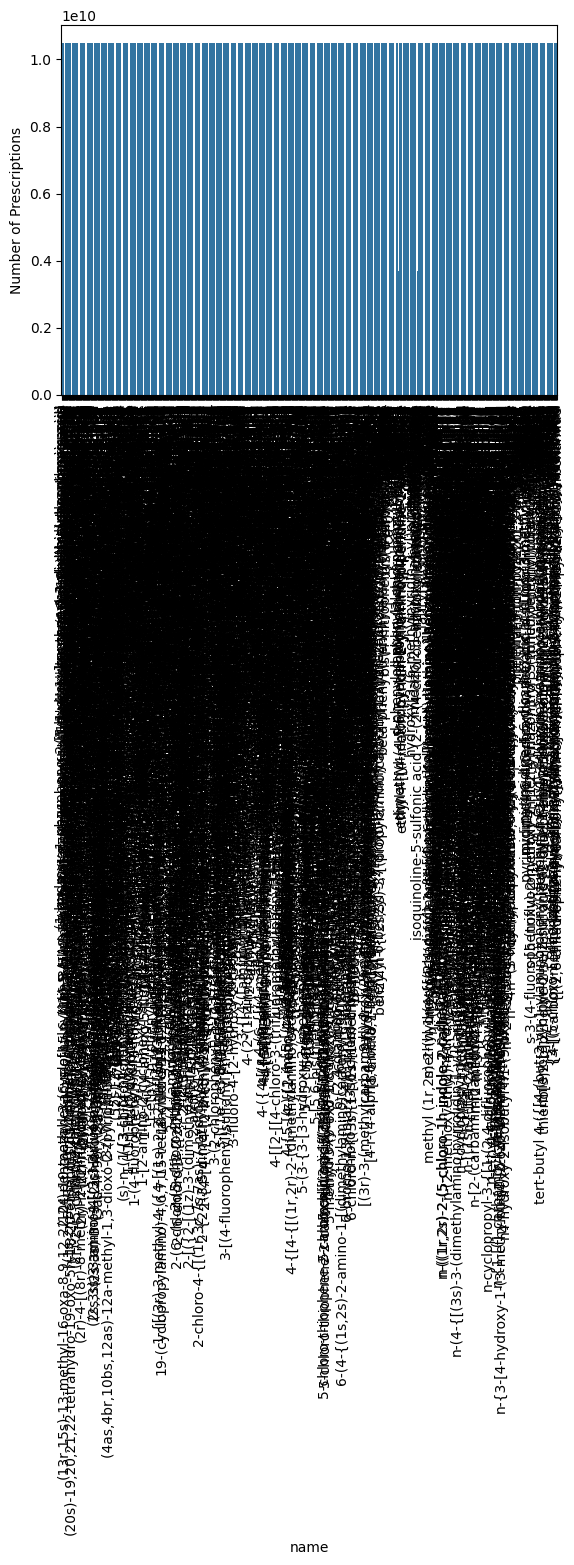

In [298]:
sns.barplot(
    data=sums[sums["Number of Prescriptions"] > 1e10],
    x="name",
    y="Number of Prescriptions",
)
plt.xticks(rotation=90)
# plt.yscale('log')
plt.show()

In [321]:
fuzz.token_sort_ratio("ergometrine", "permethrine")

82

In [339]:
list(ndc.columns)

['product_ndc',
 'generic_name',
 'labeler_name',
 'brand_name',
 'active_ingredients',
 'finished',
 'packaging',
 'listing_expiration_date',
 'openfda',
 'marketing_category',
 'dosage_form',
 'spl_id',
 'product_type',
 'route',
 'marketing_start_date',
 'product_id',
 'application_number',
 'brand_name_base',
 'pharm_class',
 'brand_name_suffix',
 'dea_schedule',
 'marketing_end_date']

In [344]:
ndc["product_ndc"]

0         72205-211
1         72205-249
2         72205-261
3         72205-265
4         72208-311
            ...    
138891    72476-473
138892    72476-623
138893    72476-630
138894    72476-847
138895    72476-875
Name: product_ndc, Length: 118503, dtype: object

In [380]:
ndc["packaging"][0]  # [0]['package_ndc'].split('-')

[{'package_ndc': '72205-211-05',
  'description': '500 TABLET, FILM COATED in 1 BOTTLE (72205-211-05)',
  'marketing_start_date': '20230220',
  'sample': False},
 {'package_ndc': '72205-211-30',
  'description': '30 TABLET, FILM COATED in 1 BOTTLE (72205-211-30)',
  'marketing_start_date': '20230220',
  'sample': False},
 {'package_ndc': '72205-211-90',
  'description': '90 TABLET, FILM COATED in 1 BOTTLE (72205-211-90)',
  'marketing_start_date': '20230220',
  'sample': False}]

In [381]:
get_ndc_list = lambda x: if x[0]['package_ndc'].split('-')
ndc['packaging'].dropna().apply(get_ndc_list)

IndexError: list index out of range

In [38]:
medicaid["Labeler Code"].astype(str).apply(len).value_counts()

Labeler Code
5    2233390
3    1225595
2     381947
1      93336
4       1814
Name: count, dtype: int64

In [ ]:
pd.merge(medicaid)

In [76]:
get_ndc_len = lambda x: len(str(x))
medicaid["NDC"].apply(get_ndc_len).value_counts()

NDC
11    2561609
9      996724
8      303047
7       73113
10       1589
Name: count, dtype: int64

In [77]:
medicaid_ndc = (
    medicaid["Labeler Code"].astype(str)
    + "0"
    + "-"
    + medicaid["Product Code"].astype(str)
    + "-"
    + medicaid["Package Size"].astype(str)
)

In [78]:
get_ndc = lambda x: x[0]["package_ndc"] if len(x) > 0 else 0
ndc_ndc = ndc["packaging"].dropna().apply(get_ndc)

In [79]:
def ndc_converter(ndc: str):
    ndc_split = str(ndc).split("-")
    if len(ndc_split) == 3:
        lb, pr, pk = ndc_split
    else:
        return 0
    if len(lb) == 4:  # Format: 4-4-2
        lb = lb.zfill(5)  # Add 1 zero to the first part
    elif len(pr) == 3:  # Format: 5-3-2
        pr = pr.zfill(4)  # Add 1 zero to the second part
    elif len(pk) == 1:  # Format: 5-4-1
        pk = pk.zfill(2)  # Add 1 zero to the third part
    if len(lb + pr + pk) == 11:
        return "-".join([lb, pr])
    else:
        return 0

In [81]:
s = 0
codes = []
ndc1 = medicaid_ndc.apply(ndc_converter).unique()
ndc2 = ndc_ndc.apply(ndc_converter).unique()
for code in ndc1:
    print(code)
    s += int(code in ndc2)
s

0
01080-3806
01080-3807
01080-4901
01080-4903
01080-4904
01080-4906
01080-4907
01080-5013
01080-5014
01080-5022
01080-5026
01080-5027
01260-2310
01260-2312
01260-2342
01310-2055
01310-2104
01310-2164
01310-2200
01310-2209
01310-2309
01310-4213
01310-4220
01310-4330
01310-4501
01310-5038
01310-5066
01310-5129
01310-5131
01310-5134
01430-1020
01430-1025
01430-1080
01430-1085
01430-1090
01430-1095
01430-1171
01430-1172
01430-1173
01430-1176
01430-1180
01430-1200
01430-1201
01430-1227
01430-1248
01430-1257
01430-1261
01430-1445
01430-1450
01430-1455
01430-1473
01430-1475
01430-1477
01430-1480
01430-1490
01430-1495
01430-1497
01430-1600
01430-1715
01430-1720
01430-1764
01430-1765
01430-1767
01430-1769
01430-1771
01430-1772
01430-1785
01430-2073
01430-2125
01430-3126
01430-3130
01430-3141
01430-3142
01430-3145
01450-2472
01520-1000
01690-1833
01690-1834
01690-1835
01690-1837
01690-2440
01690-2447
01690-3473
01690-3474
01690-3477
01690-7778
01720-2057
01720-2083
01720-2089
01720-2130
01720-21

KeyboardInterrupt: 

: 

In [36]:
ndc["packaging"]

0         [{'package_ndc': '72205-211-05', 'description'...
1         [{'package_ndc': '72205-249-01', 'description'...
2         [{'package_ndc': '72205-261-30', 'description'...
3         [{'package_ndc': '72205-265-07', 'description'...
4         [{'package_ndc': '72208-311-01', 'description'...
                                ...                        
138891    [{'package_ndc': '72476-473-01', 'description'...
138892    [{'package_ndc': '72476-623-63', 'description'...
138893    [{'package_ndc': '72476-630-26', 'description'...
138894    [{'package_ndc': '72476-847-22', 'description'...
138895    [{'package_ndc': '72476-875-10', 'description'...
Name: packaging, Length: 118503, dtype: object

In [2]:
import pandas as pd

zinc_ids = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=["ZINC ID of Ligand"],
).dropna()

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_3905/3472174415.py:2: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  zinc_ids = pd.read_csv(


In [8]:
zinc_ids["ZINC ID of Ligand"].unique().shape

(439833,)

In [ ]:
names = ["Wes", "Amelie", "Gregor", "Daphne", "Guillaume"]

In [26]:
import pandas as pd

zinc_ids = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=["ZINC ID of Ligand"],
).dropna()
{
    name: zinc_ids["ZINC ID of Ligand"].unique()[i::5]
    for i, name in zip(range(5), ["Wes", "Amelie", "Gregor", "Daphne", "Guillaume"])
}

{'Wes': array(['ZINC03948988', 'ZINC13604438', 'ZINC03810793', ...,
        'ZINC43491361', 'ZINC13642206', 'ZINC43481893'], dtype=object),
 'Amelie': array(['ZINC03826079', 'ZINC14907373', 'ZINC14907377', ...,
        'ZINC13679299', 'ZINC00849587', 'ZINC44220812'], dtype=object),
 'Gregor': array(['ZINC14907367', 'ZINC13604416', 'ZINC14907379', ...,
        'ZINC43481977', 'ZINC44018377', 'ZINC13642221'], dtype=object),
 'Daphne': array(['ZINC14907369', 'ZINC13604434', 'ZINC96126610', ...,
        'ZINC13473138', 'ZINC13679302', 'ZINC13473137'], dtype=object),
 'Guillaume': array(['ZINC14907371', 'ZINC14907375', 'ZINC14907381', ...,
        'ZINC44018288', 'ZINC13642203', 'ZINC43511374'], dtype=object)}

In [22]:
len(zinc_ids["ZINC ID of Ligand"].unique()[0::5])

87967

439835